This code is to mostly plot and analize data that will be used to feed an MLC, namely for this project, the LSM6DSOX accelerometer MLC. It is highly recomended to run all of the code.

This first snipit of code has the necessary includes and some function defenitions for later use. All of these functions receive a signal and returns the desired feature for this signal with the choosen window size.

P2P stands for peak to peak. This function does the subtraction between the maximum and minimum of the signal.

Var stand for variance. This function does the following equation: $ (\frac{\sum_{k=0}^{WL-1} I_{k}^{2}}{WL}) - (\frac{\sum_{k=0}^{WL-1} I_{k}}{WL})^{2} $

Energy is self explanatory and is applies the following equation: $ \sum_{k=0}^{WL-1} I_{k}^{2} $

All of these functions were taken from the official application note:
https://www.st.com/content/ccc/resource/technical/document/application_note/group1/5f/d8/0a/fe/04/f0/4c/b8/DM00563460/files/DM00563460.pdf/jcr:content/translations/en.DM00563460.pdf

In [1]:
import serial as serial
import pandas as pandas
import time
import matplotlib.pyplot as plt
import csv
import math
import os
import scipy.signal

def p2p(data,window_size):
    result=[]
    i=0
    data_window=[]
    for x in data:
        i+=1
        data_window.append(x)
        if i>=window_size:
            i=0
            result.append(max(data_window)-min(data_window))
            data_window=[]
    return result

def var(data,window_size):
    result=[]
    i=0
    data_window=[]
    data_window_2=[]
    for x in data:
        i+=1
        data_window.append(x)
        data_window_2.append(x*x)
        if i>=window_size:
            i=0
            second=(sum(data_window)/window_size)
            result.append((sum(data_window_2)/window_size)-(second*second))
            data_window=[]
            data_window_2=[]
    return result

def energy(data,window_size):
    result=[]
    i=0
    data_window=[]
    for x in data:
        i+=1
        data_window.append(x*x)
        if i>=window_size:
            i=0
            result.append(sum(data_window))
            data_window=[]
    return result

The following code contains the function process_raw which takes the raw lines of the files and turns it into floats and returns the average of each axix.

The remainder of the code is simple read files and turns into numbers for further use.

In [2]:
def process_raw(raw_lines):
    result=[]
    med_x=0
    med_y=0
    med_z=0
    for line in raw_lines:
        str_list=list(line.strip().split(" "))
        try:
            float_list=[float(x) for x in str_list]
            med_x+=float_list[0]
            med_y+=float_list[1]
            med_z+=float_list[2]
            result.append(float_list)
        except:
            continue
    med_x=med_x/len(result)
    med_y=med_y/len(result)
    med_z=med_z/len(result)
    return result,med_x,med_y,med_z

os.chdir("..")
os.chdir("Data")
os.chdir("motor")
file_idle=open("idle_motor.txt",'r')
file_shake=open("shake_motor.txt",'r')
#os.chdir(r'C:\Users\danip\OneDrive\Desktop\IST-vibration\Data\coffe_dataset_v1')
#file_idle=open("data0.txt",'r')
#file_shake=open("data1.txt",'r')
idle_data_raw=file_idle.readlines()
shake_data_raw=file_shake.readlines()
idle_float,med_idle_x,med_idle_y,med_idle_z=process_raw(idle_data_raw)
shake_float,med_shake_x,med_shake_y,med_shake_z=process_raw(shake_data_raw)

The following code turns the seperate axis into a joint axis. There are some inputs made by the user to either filter throught a high pass filter ot take of the averages calculated in the previous snipit. It is important to note that, if the user utilized the HP filter, it will print the coeficients utilized. These coeficients can be utilized in the MLC. The result is ploted.

a: [ 1.         -0.78344997]
b: [ 0.89172498 -0.89172498]


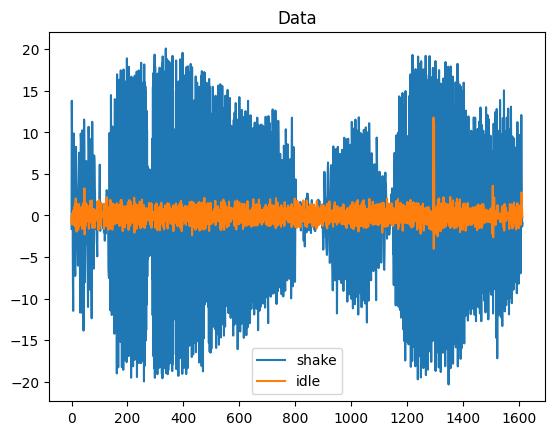

In [3]:
idle_V=[]
shake_V=[]
idle_float_offset=[]
shake_float_offset=[]
filter_mode=input("Filter signals?(y/n):")
if filter_mode=='y':
    filter_frequency=float(input("Enter filter frequency:"))
    for line in idle_float:
        idle_V.append(math.sqrt(line[0]*line[0]+line[1]*line[1]+line[2]*line[2]))
    for line in shake_float:
        shake_V.append(math.sqrt(line[0]*line[0]+line[1]*line[1]+line[2]*line[2]))
    b,a=scipy.signal.butter(1,2*filter_frequency/26,btype='high')
    print("a:",a)
    print("b:",b)
    idle_V=scipy.signal.filtfilt(b,a,idle_V)
    shake_V=scipy.signal.filtfilt(b,a,shake_V)
if filter_mode=='n':
    offset_mode=input("Take off indle offset?(y/n):")
    if offset_mode=='y':
        for line in idle_float:
            new_line=[line[0]-med_idle_x,line[1]-med_idle_y,line[2]-med_idle_z]
            idle_float_offset.append(new_line)
        for line in shake_float:
            new_line=[line[0]-med_idle_x,line[1]-med_idle_y,line[2]-med_idle_z]
            shake_float_offset.append(new_line)
        with open("offset_idle.txt",'w') as idle_file:
            for line in idle_float_offset:
                idle_file.write(" ".join(str(numb) for numb in line))
                idle_file.write('\n')
        with open("offset_shake.txt",'w') as idle_file:
            for line in shake_float_offset:
                idle_file.write(" ".join(str(numb) for numb in line))
                idle_file.write('\n')
        for line in idle_float_offset:
            idle_V.append(math.sqrt(line[0]*line[0]+line[1]*line[1]+line[2]*line[2]))
        for line in shake_float_offset:
            shake_V.append(math.sqrt(line[0]*line[0]+line[1]*line[1]+line[2]*line[2]))
    else:
        for line in idle_float:
            idle_V.append(math.sqrt(line[0]*line[0]+line[1]*line[1]+line[2]*line[2]))
        for line in shake_float:
            shake_V.append(math.sqrt(line[0]*line[0]+line[1]*line[1]+line[2]*line[2]))
plt.plot(shake_V,label="shake")
plt.plot(idle_V,label="idle")
plt.title("Data")
plt.legend()
plt.show()

This snipit calculates the desired feature and prints the results.

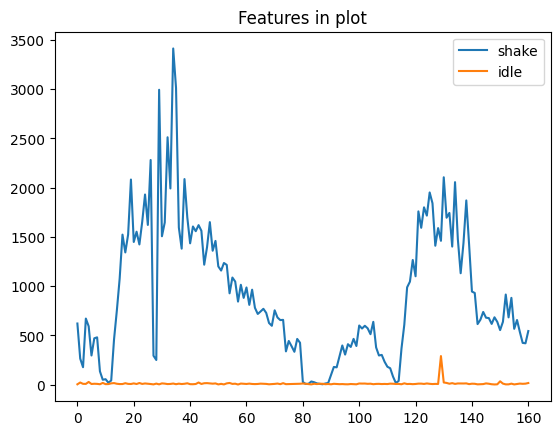

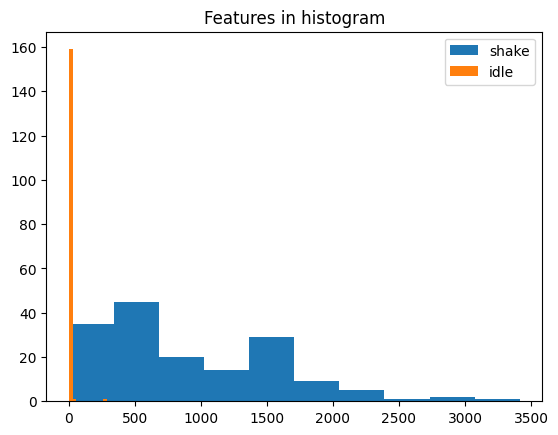

In [4]:
window_size=int(input("Enter window size:"))
user_mode=input("Enter desired feature(P,V,E):")
if user_mode=='E':
    shake_features=energy(shake_V,window_size)
    idle_features=energy(idle_V,window_size)
elif user_mode=='V':
    shake_features=var(shake_V,window_size)
    idle_features=var(idle_V,window_size)
else:
    shake_features=p2p(shake_V,window_size)
    idle_features=p2p(idle_V,window_size)
plt.figure()
plt.plot(shake_features,label="shake")
plt.plot(idle_features,label="idle")
plt.legend()
plt.title("Features in plot")
plt.figure()
plt.hist(shake_features,label='shake')
plt.hist(idle_features,label='idle')
plt.title("Features in histogram")
plt.legend()
plt.show()

This last part is to analize result files ini which there are 2 additional values in lines: the predicted result and ground truth. Most of the logic is identical to the previous code. The numenclature of the files might change as this project goes on but so far it is as such:

From what machine the MLC is built on to what machine it is experemented on. Ex:motor_to_coffe -> trained on motor data and experemented on the coffe machine.

E/V/P-> what feature it uses. So far it will only be used one feature but as this project goes on more might be used.
F-> indicated if there is a filter being used. If there is, so far, its a HBP filter with low cutoff frequencies (1 or 0.1 Hz) to remove DC component.

As a very short sidenote, the file motor_to_coffe_EF.txt has some misslabeling, namely in the transitions between idle and shake, so the results from that file are very preliminary.

          SHAKE     IDLE
SHAKE      1543       89
IDLE       31       1025
Accuracy: 0.9553571428571429
Precision: 0.9454656862745098
Recall: 0.9803049555273189


a: [ 1.         -0.78344997]
b: [ 0.89172498 -0.89172498]


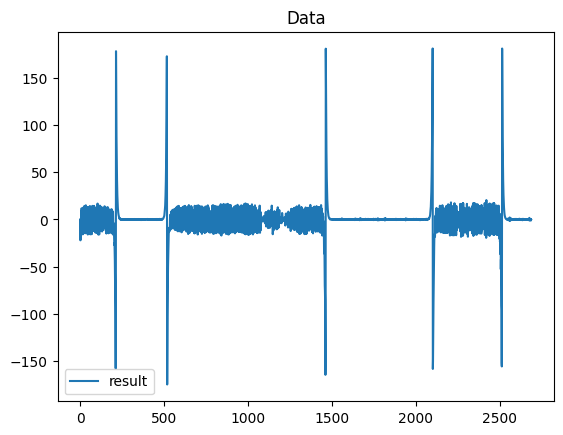

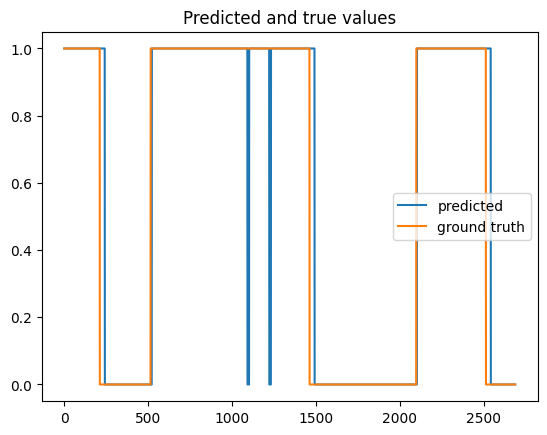

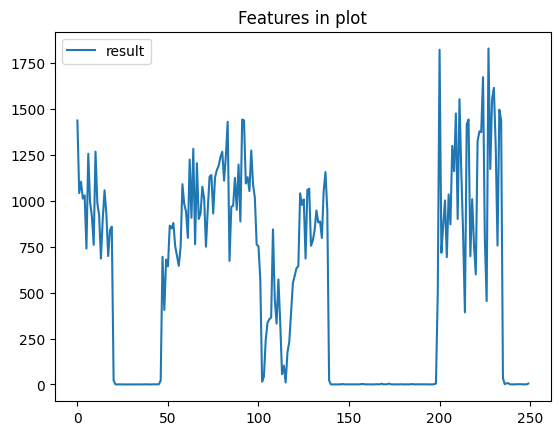

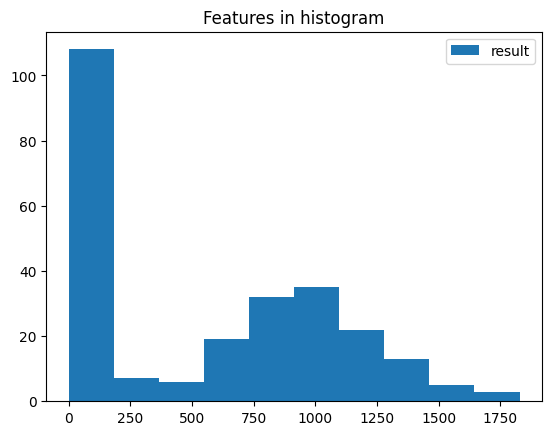

In [31]:
os.chdir(r'C:\Users\danip\OneDrive\Desktop\IST-vibration\Data\results')
file_result=open("motor_to_motor_EF.txt",'r')
result_data_raw=file_result.readlines()
result_float,med_res_x,med_res_y,med_res_z=process_raw(result_data_raw)
TP=0
TN=0
FP=0
FN=0
print("          SHAKE     IDLE")
for line in result_float:
    if line[3]==1 and line[4]==1:
        TP+=1
    elif line[3]==1 and line[4]==0:
        FP+=1
    elif line[3]==0 and line[4]==0:
        TN+=1
    elif line[3]==0 and line[4]==1:
        FN+=1
print("SHAKE     ",TP,"     ",FP)
print("IDLE      ",FN,"     ",TN)
print("Accuracy:",(TP+TN)/(TP+TN+FP+FN))

print("Precision:",TP/(TP+FP))
print("Recall:",TP/(TP+FN))
result_V=[]
for line in result_float:
    result_V.append(math.sqrt(line[0]*line[0]+line[1]*line[1]+line[2]*line[2]))
filter_mode=input("Filter signals?(y/n):")
if filter_mode=='y':
    filter_frequency=float(input("Enter filter frequency:"))
    b,a=scipy.signal.butter(1,2*filter_frequency/26,btype='high')
    print("a:",a)
    print("b:",b)
    result_V=scipy.signal.filtfilt(b,a,result_V)
plt.plot(result_V,label="result")
plt.title("Data")
plt.legend()
plt.show()
GT=[]
Pred=[]
for line in result_float:
    GT.append(line[4])
    Pred.append(line[3])
plt.plot(Pred,label='predicted')
plt.plot(GT,label='ground truth')
plt.legend()
plt.title("Predicted and true values")
plt.show()

window_size=10
filter_feautures=input("Filter features?(y/n):")
result_features=energy(result_V,window_size)
if filter_feautures=='y':
    result_features=[i for i in result_features if i<2000]
plt.figure()
plt.plot(result_features,label='result')
plt.legend()
plt.title("Features in plot")
plt.figure()
plt.hist(result_features,label='result')
plt.title("Features in histogram")
plt.legend()
plt.show()